3D X-ray Transform Comparison
=============================

This example shows how to define a SCICO native 3D X-ray transform using
ASTRA toolbox conventions and vice versa.

In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import scico.linop.xray.astra as astra
from scico import plot
from scico.examples import create_block_phantom
from scico.linop.xray import XRayTransform3D
from scico.util import ContextTimer, Timer
plot.config_notebook_plotting()

Create a ground truth image and set detector dimensions.

In [2]:
N = 64
# use rectangular volume to check whether axes are handled correctly
in_shape = (N + 1, N + 2, N + 3)
x = create_block_phantom(in_shape)
x = jnp.array(x)

# use rectangular detector to check whether axes are handled correctly
out_shape = (N, N + 1)

Set up SCICO projection.

In [3]:
num_angles = 3


rot_X = 90.0 - 16.0
rot_Y = np.linspace(0, 180, num_angles, endpoint=False)
angles = np.stack(np.broadcast_arrays(rot_X, rot_Y), axis=-1)
matrices = XRayTransform3D.matrices_from_euler_angles(
    in_shape, out_shape, "XY", angles, degrees=True
)

Specify geometry using SCICO conventions and project.

In [4]:
num_repeats = 3

timer_scico = Timer()
with ContextTimer(timer_scico, "init"):
    H_scico = XRayTransform3D(in_shape, matrices, out_shape)

with ContextTimer(timer_scico, "first_fwd"):
    y_scico = H_scico @ x
    jax.block_until_ready(y_scico)

with ContextTimer(timer_scico, "avg_fwd"):
    for _ in range(num_repeats):
        y_scico = H_scico @ x
        jax.block_until_ready(y_scico)
timer_scico.td["avg_fwd"] /= num_repeats

with ContextTimer(timer_scico, "first_back"):
    HTy_scico = H_scico.T @ y_scico

with ContextTimer(timer_scico, "avg_back"):
    for _ in range(num_repeats):
        HTy_scico = H_scico.T @ y_scico
        jax.block_until_ready(HTy_scico)
timer_scico.td["avg_back"] /= num_repeats

Convert SCICO geometry to ASTRA and project.

In [5]:
vectors_from_scico = astra.convert_from_scico_geometry(in_shape, matrices, out_shape)

timer_astra = Timer()
with ContextTimer(timer_astra, "init"):
    H_astra_from_scico = astra.XRayTransform3D(
        input_shape=in_shape, det_count=out_shape, vectors=vectors_from_scico
    )

with ContextTimer(timer_astra, "first_fwd"):
    y_astra_from_scico = H_astra_from_scico @ x
    jax.block_until_ready(y_astra_from_scico)

with ContextTimer(timer_astra, "avg_fwd"):
    for _ in range(num_repeats):
        y_astra_from_scico = H_astra_from_scico @ x
        jax.block_until_ready(y_astra_from_scico)
timer_astra.td["avg_fwd"] /= num_repeats

with ContextTimer(timer_astra, "first_back"):
    HTy_astra_from_scico = H_astra_from_scico.T @ y_astra_from_scico

with ContextTimer(timer_astra, "avg_back"):
    for _ in range(num_repeats):
        HTy_astra_from_scico = H_astra_from_scico.T @ y_astra_from_scico
        jax.block_until_ready(HTy_astra_from_scico)
timer_astra.td["avg_back"] /= num_repeats

Specify geometry with ASTRA conventions and project.

In [6]:
angles = np.random.rand(num_angles) * 180  # random projection angles
det_spacing = [1.0, 1.0]
vectors = astra.angle_to_vector(det_spacing, angles)

H_astra = astra.XRayTransform3D(input_shape=in_shape, det_count=out_shape, vectors=vectors)

y_astra = H_astra @ x
HTy_astra = H_astra.T @ y_astra

Convert ASTRA geometry to SCICO and project.

In [7]:
P_from_astra = astra._astra_to_scico_geometry(H_astra.vol_geom, H_astra.proj_geom)
H_scico_from_astra = XRayTransform3D(in_shape, P_from_astra, out_shape)

y_scico_from_astra = H_scico_from_astra @ x
HTy_scico_from_astra = H_scico_from_astra.T @ y_scico_from_astra

Print timing results.

In [8]:
print(f"init         astra    {timer_astra.td['init']:.2e} s")
print(f"init         scico    {timer_scico.td['init']:.2e} s")
print("")
for tstr in ("first", "avg"):
    for dstr in ("fwd", "back"):
        for timer, pstr in zip((timer_astra, timer_scico), ("astra", "scico")):
            print(f"{tstr:5s}  {dstr:4s}  {pstr}    {timer.td[tstr + '_' + dstr]:.2e} s")
        print()

init         astra    8.39e-05 s
init         scico    8.95e-01 s

first  fwd   astra    6.16e-02 s
first  fwd   scico    5.45e-02 s

first  back  astra    5.11e-02 s
first  back  scico    6.22e-01 s

avg    fwd   astra    5.32e-02 s
avg    fwd   scico    4.46e-02 s

avg    back  astra    5.20e-02 s
avg    back  scico    4.54e-02 s



Show projections.

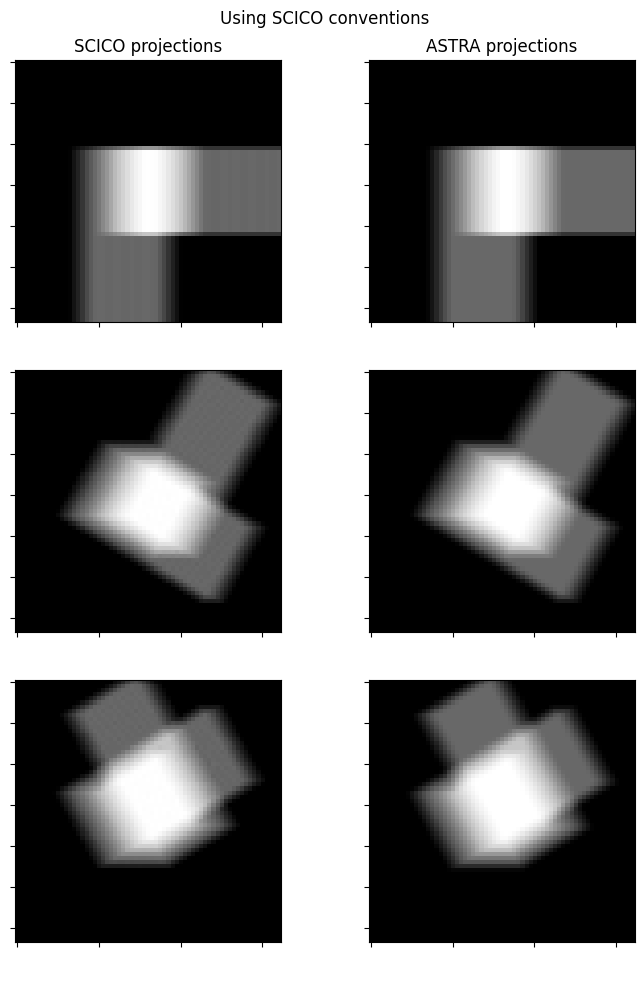

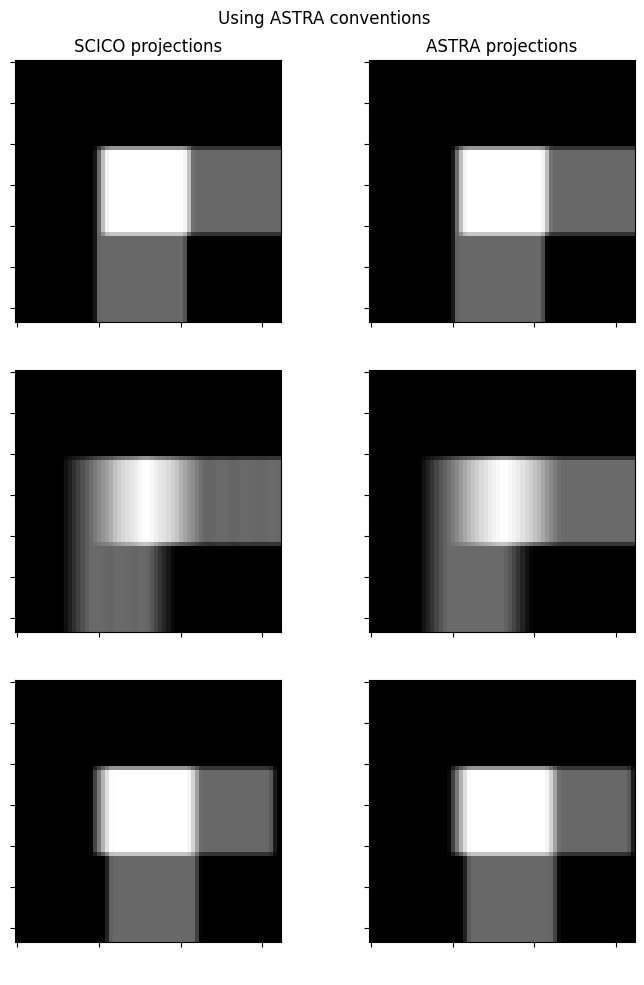

In [9]:
fig, ax = plot.subplots(nrows=3, ncols=2, figsize=(8, 10))
plot.imview(y_scico[0], title="SCICO projections", cbar=None, fig=fig, ax=ax[0, 0])
plot.imview(y_scico[1], cbar=None, fig=fig, ax=ax[1, 0])
plot.imview(y_scico[2], cbar=None, fig=fig, ax=ax[2, 0])
plot.imview(y_astra_from_scico[:, 0], title="ASTRA projections", cbar=None, fig=fig, ax=ax[0, 1])
plot.imview(y_astra_from_scico[:, 1], cbar=None, fig=fig, ax=ax[1, 1])
plot.imview(y_astra_from_scico[:, 2], cbar=None, fig=fig, ax=ax[2, 1])
fig.suptitle("Using SCICO conventions")
fig.tight_layout()
fig.show()

fig, ax = plot.subplots(nrows=3, ncols=2, figsize=(8, 10))
plot.imview(y_scico_from_astra[0], title="SCICO projections", cbar=None, fig=fig, ax=ax[0, 0])
plot.imview(y_scico_from_astra[1], cbar=None, fig=fig, ax=ax[1, 0])
plot.imview(y_scico_from_astra[2], cbar=None, fig=fig, ax=ax[2, 0])
plot.imview(y_astra[:, 0], title="ASTRA projections", cbar=None, fig=fig, ax=ax[0, 1])
plot.imview(y_astra[:, 1], cbar=None, fig=fig, ax=ax[1, 1])
plot.imview(y_astra[:, 2], cbar=None, fig=fig, ax=ax[2, 1])
fig.suptitle("Using ASTRA conventions")
fig.tight_layout()
fig.show()

Show back projections.

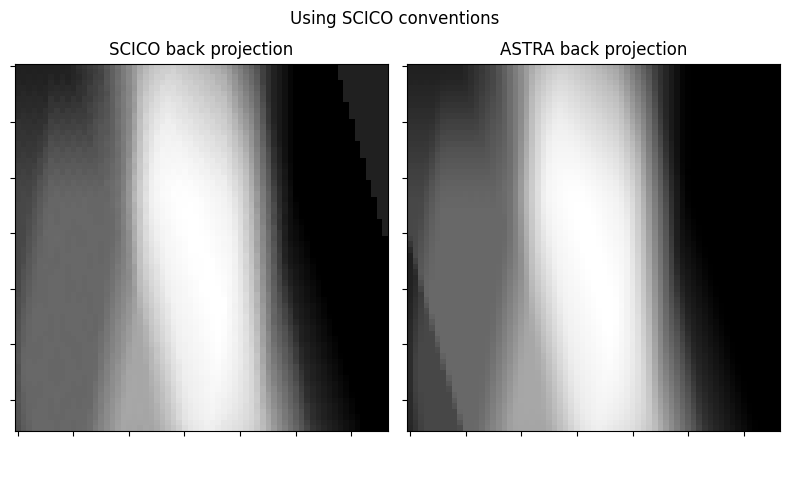

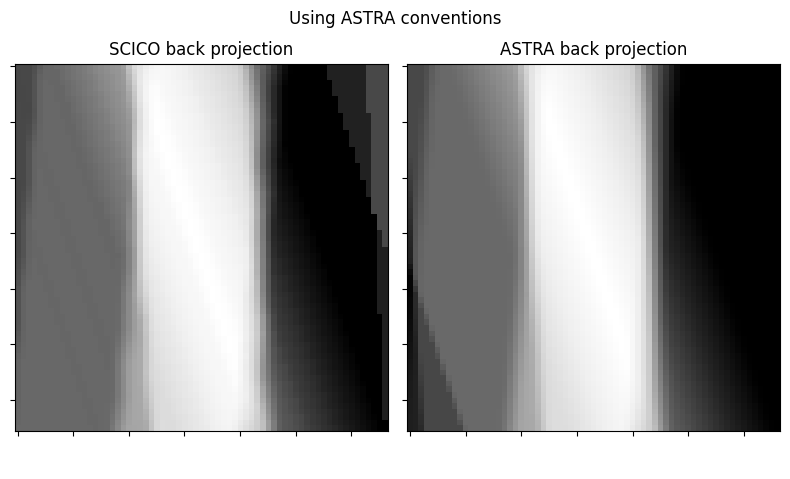

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(8, 5))
plot.imview(HTy_scico[N // 2], title="SCICO back projection", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    HTy_astra_from_scico[N // 2], title="ASTRA back projection", cbar=None, fig=fig, ax=ax[1]
)
fig.suptitle("Using SCICO conventions")
fig.tight_layout()
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(8, 5))
plot.imview(
    HTy_scico_from_astra[N // 2], title="SCICO back projection", cbar=None, fig=fig, ax=ax[0]
)
plot.imview(HTy_astra[N // 2], title="ASTRA back projection", cbar=None, fig=fig, ax=ax[1])
fig.suptitle("Using ASTRA conventions")
fig.tight_layout()
fig.show()